In [1]:
import os
import Augmentor
import zipfile
import random
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
local_zip = 'Discoloration.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Dataset/')
zip_ref.close()

local_zip2 = 'Periodontal.zip'
zip_ref2    = zipfile.ZipFile(local_zip2, 'r')
zip_ref2.extractall('Dataset/') 
zip_ref2.close()

In [3]:
print(len(os.listdir('Dataset/Dental Discoloration')))
print(len(os.listdir('Dataset/Periodontal')))

440
417


In [105]:
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [106]:
AugmentData("Dataset/Discoloration/", 1000)
AugmentData("Dataset/Periodontal/", 1000)
AugmentData("Dataset/Healthy/", 1000)

Initialised with 40 image(s) found.
Output directory set to Dataset/Discoloration/..

Processing <PIL.Image.Image image mode=RGB size=436x336 at 0x207CF6C5C70>: 100%|█| 1000/1000 [00:03<00:00, 313.43 Sampl


Initialised with 17 image(s) found.
Output directory set to Dataset/Periodontal/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x675 at 0x207CF72A2E0>: 100%|█| 1000/1000 [00:01<


Initialised with 90 image(s) found.
Output directory set to Dataset/Healthy/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x328 at 0x2073F350610>: 100%|█| 1000/1000 [00:02<0


In [108]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Discoloration_SOURCE_DIR = "Dataset/Discoloration/"
Periodontal_SOURCE_DIR = "Dataset/Periodontal/"
Healthy_SOURCE_DIR = "Dataset/Healthy/"

TRAINING_Discoloration_DIR = "Dataset_Real/training/Dental Discoloration/"
TRAINING_Periodontal_DIR = "Dataset_Real/training/Periodontal/"
TRAINING_Healthy_DIR = "Dataset_Real/training/Healthy/"

TESTING_Discoloration_DIR = "Dataset_Real/testing/Dental Discoloration/"
TESTING_Periodontal_DIR = "Dataset_Real/testing/Periodontal/"
TESTING_Healthy_DIR = "Dataset_Real/testing/Healthy/"

split_size = .8
split_data(Discoloration_SOURCE_DIR, TRAINING_Discoloration_DIR, TESTING_Discoloration_DIR, split_size)
split_data(Periodontal_SOURCE_DIR, TRAINING_Periodontal_DIR, TESTING_Periodontal_DIR, split_size)
split_data(Healthy_SOURCE_DIR, TRAINING_Healthy_DIR, TESTING_Healthy_DIR, split_size)

In [2]:
TRAINING_DIR = "Dataset_Real/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "Dataset_Real/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [6]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [7]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

In [8]:
history = model.fit(train_generator,
                    steps_per_epoch=40,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=20,
                    verbose=2)

Epoch 1/20
40/40 - 8s - loss: 1.0874 - accuracy: 0.3525 - val_loss: 1.0335 - val_accuracy: 0.4550 - 8s/epoch - 195ms/step
Epoch 2/20
40/40 - 6s - loss: 1.0222 - accuracy: 0.5038 - val_loss: 0.9481 - val_accuracy: 0.5150 - 6s/epoch - 143ms/step
Epoch 3/20
40/40 - 5s - loss: 0.9708 - accuracy: 0.5250 - val_loss: 0.9002 - val_accuracy: 0.6050 - 5s/epoch - 134ms/step
Epoch 4/20
40/40 - 5s - loss: 0.8009 - accuracy: 0.6150 - val_loss: 0.7186 - val_accuracy: 0.6750 - 5s/epoch - 135ms/step
Epoch 5/20
40/40 - 5s - loss: 0.7143 - accuracy: 0.6825 - val_loss: 0.7327 - val_accuracy: 0.6150 - 5s/epoch - 135ms/step
Epoch 6/20
40/40 - 5s - loss: 0.6998 - accuracy: 0.6963 - val_loss: 0.7110 - val_accuracy: 0.6200 - 5s/epoch - 134ms/step
Epoch 7/20
40/40 - 5s - loss: 0.6570 - accuracy: 0.7088 - val_loss: 0.5592 - val_accuracy: 0.7550 - 5s/epoch - 134ms/step
Epoch 8/20
40/40 - 5s - loss: 0.5476 - accuracy: 0.7563 - val_loss: 0.6404 - val_accuracy: 0.6950 - 5s/epoch - 132ms/step
Epoch 9/20
40/40 - 5s - 

In [10]:
#classes 
class_names =  ["Discloration", "Healthy", "Periodontal"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Discloration   0
Healthy   1
Periodontal   2


In [16]:
import numpy as np
from keras.preprocessing import image

path = "3.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 0. 1.]]


[0]
Discloration


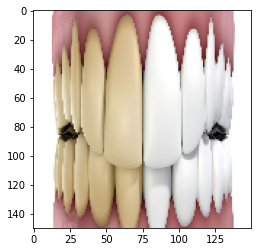

In [19]:
import matplotlib.pyplot as plt

image_path = "1.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)

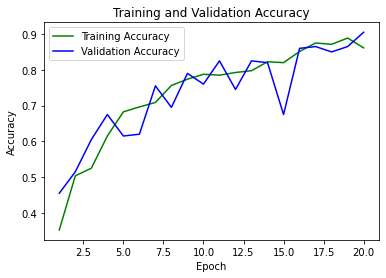

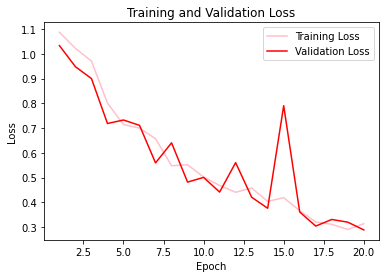

In [20]:
#plotting training values

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()